In [13]:
import torch # version 2.1.2
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
import cv2
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.nn.parallel import DataParallel
from model import YoloV1
from resnet_model import YoloV1_Pretrained
from dataset import VOCDataset
from loss import YoloLoss
from utils import *

seed = 3301 #pseudorandom seed, gets the same dataset loading
torch.manual_seed(seed)

torch.autograd.set_detect_anomaly(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", DEVICE)

Using device cuda


In [2]:
# Hyperparameters for our model
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 50
WEIGHT_DECAY = 0    # no regularization in order for fast training
EPOCHS = 50

# Other variables for training
NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FNAME = "overfit.pth.tar"
SAVE_MODEL_FNAME = "yolotrained.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"

# Creating the Datasets

In [3]:
# This cell generates a validation set
import numpy as np
np.random.seed(3301)

def split_lines(input_file, output_file_1, output_file_2, split_ratio=0.8):
    # Read lines from the input file
    with open(input_file, 'r') as infile:
        lines = infile.readlines()

    total_lines = len(lines)

    # Create a boolean mask for random selection
    random_mask = np.random.choice([True, False], total_lines, p=[split_ratio, 1.0 - split_ratio])

    # Use boolean indexing to get the selected lines
    random_lines = np.array(lines)[random_mask]

    # Write the selected lines to the first output file
    with open(output_file_1, 'w') as outfile_1:
        outfile_1.writelines(random_lines)

    # Use boolean indexing to get the remaining lines
    remaining_lines = np.array(lines)[~random_mask]

    # Write the remaining lines to the second output file
    with open(output_file_2, 'w') as outfile_2:
        outfile_2.writelines(remaining_lines)
    
input_file = 'data/train.csv'
output_file_1 = 'data/train_trimmed.csv'
output_file_2 = 'data/validation.csv'

input_file = 'data/100examples.csv'
output_file_1 = 'data/100examples_trimmed.csv'
output_file_2 = 'data/100examples_validation.csv'
# split_lines(input_file, output_file_1, output_file_2, 0.8)

In [4]:
# This cell creates the 3 datasets: train_trimmed, validation, and test

transform = transforms.Compose([
    transforms.Resize((448, 448)), 
    transforms.ToTensor()
    ])

# creating datasets/dataloaders

train_trimmed_dataset = VOCDataset(
    'data/train_trimmed.csv',
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

train_trimmed_loader = DataLoader(
    dataset = train_trimmed_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = True,
    drop_last = False       # True for training, and since numDatapoints > batchSize
)

validation_dataset = VOCDataset(
    'data/validation.csv', 
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

validation_loader = DataLoader(  # we need a loader to input into get_bboxes
    dataset = validation_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = True,
    drop_last = False       
)

test_dataset = VOCDataset(
    "data/test.csv", 
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

test_loader = DataLoader( # THIS IS NOT SHUFFLED SO WE CAN PLOT VISUALIZATIONS
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = False,
    drop_last = True
)

In [5]:
# This cell defines a function to train the model on the all the datapoints in the train_loader
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE) 
        # x has shape torch.Size([batchSize, 3, 448, 448])
        # y has shape torch.Size([batchSize, 7, 7, 30])
        
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        
        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())
    
    total_loss = sum(mean_loss)/len(mean_loss)
    return total_loss

def yololoss_validation_evaluation(loader, model, loss_fn):
    """Given a dataset, evaluates the model's defined yolo loss on that dataset and returns it"""
    mean_loss = []
    
    model.eval()
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE) 
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
    model.train() # return the model in training mode
    
    total_loss = sum(mean_loss)/len(mean_loss)
    return total_loss


# Training Loop on VOC Dataset (Transfer Learning / Fine-tuning)

In [ ]:
# TRAINING THE MODEL (takes 7 minutes per epoch)
model = YoloV1_Pretrained(S = 7, B = 2, C = 20).to(DEVICE)
model = DataParallel(model)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FNAME), model, optimizer)

# performance tracking
mAP_train_list = []
mAP_valid_list = []
avgloss_train_list = []
avgloss_valid_list = []
best_valid_mAP = 0.5

# trains through the entire dataset once
model.train()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} Results:")
    # get_bboxes puts the model in .eval() mode to evaluate and then switches it back to model.train() when finished evaluating bboxes
    pred_boxes_train, target_boxes_train = get_bboxes(train_trimmed_loader, model, iou_threshold = 0.5, prob_threshold = 0.4)
    pred_boxes_valid, target_boxes_valid = get_bboxes(validation_loader, model, iou_threshold = 0.5, prob_threshold = 0.4)
    # pred_boxes (list of lists) = [[train_idx, class_prediction, prob_score, x1, y1, x2, y2],...], each list within the big list represents a bbox
    # target_boxes = ^
    # note: the length of these lists >= numDatapoints
    
    # Calculate the mAP from our evaluated bboxes
    mAP_train = mean_average_precision(pred_boxes_train, target_boxes_train, iou_threshold=0.5, box_format="midpoint")
    mAP_valid = mean_average_precision(pred_boxes_valid, target_boxes_valid, iou_threshold=0.5, box_format="midpoint")
    mAP_train_list.append(mAP_train)
    mAP_valid_list.append(mAP_valid)
    print(f"Train mAP: {mAP_train}")
    print(f"Validation mAP: {mAP_valid}")
    
    # Calculate the average YOLO loss from our evaluated bboxes
    yolo_loss_train = train_fn(train_trimmed_loader, model, optimizer, loss_fn)
    yolo_loss_valid = yololoss_validation_evaluation(validation_loader, model, loss_fn)
    print(f"Average training loss per image: {yolo_loss_train}")
    print(f"Average validation loss per image: {yolo_loss_valid}")
    avgloss_train_list.append(yolo_loss_train)
    avgloss_valid_list.append(yolo_loss_valid)
    print()

    # early stopping - once validation mAP hits .5, we start saving the model with the best validation mAP
    if mAP_valid > best_valid_mAP:
        best_valid_mAP = mAP_valid
        torch.save(model, "yolotrained.tar")

checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}
save_checkpoint(checkpoint, filename=SAVE_MODEL_FNAME) # saves the model with torch.save

In [8]:
# this cell saves the model
torch.save(model, "yolo_resnet_pretrained.tar")

In [9]:
# this cell loads the model
tar_file_path = "yolotrained.tar"
model = torch.load(tar_file_path)
model(torch.rand(10, 3, 448, 448)) # testing if we got it :D

tensor([[ 0.8807,  0.1358, -0.6699,  ..., -0.1170, -0.4798,  0.1161],
        [ 0.7900,  0.1338, -0.6590,  ..., -0.0189, -0.3634, -0.3226],
        [ 0.9181,  0.0933, -0.6743,  ..., -0.0707, -0.5439, -0.0306],
        ...,
        [ 0.8949, -0.0743, -0.9245,  ...,  0.0564, -0.4983, -0.2872],
        [ 0.8199,  0.0577, -0.9367,  ...,  0.0990, -0.4403, -0.1835],
        [ 0.6988,  0.0890, -0.8158,  ...,  0.1070, -0.5278, -0.2102]],
       device='cuda:0', grad_fn=<GatherBackward>)

In [5]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 448, 448))

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [100, 1470]               --
├─YoloV1: 1-1                            [25, 1470]                85,787,534
├─YoloV1: 1-8                            --                        (recursive)
│    └─Sequential: 2-1                   [25, 1024, 7, 7]          60,169,152
│    └─Sequential: 2-27                  --                        (recursive)
│    │    └─CNNBlock: 3-1                [25, 64, 224, 224]        9,536
│    │    └─CNNBlock: 3-20               --                        (recursive)
├─YoloV1: 1-3                            [25, 1470]                --
├─YoloV1: 1-8                            --                        (recursive)
│    └─Sequential: 2-3                   [25, 1024, 7, 7]          --
│    └─Sequential: 2-27                  --                        (recursive)
│    │    └─CNNBlock: 3-3                [25, 64, 224, 224]        --
│    │    └─CNNBlock:

In [19]:
# Let's evaluate the model on the training set and test test: (takes about 4 min)

train_trimmed_loader_INORDER = DataLoader(
    dataset = train_trimmed_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = False,
    drop_last = False       # True for training, and since numDatapoints > batchSize
)

pred_boxes_train, target_boxes_train = get_bboxes(train_trimmed_loader_INORDER, model, iou_threshold = 0.5, prob_threshold = 0.4)
pred_boxes_test, target_boxes_test = get_bboxes(test_loader, model, iou_threshold = 0.5, prob_threshold = 0.25)

print("Final Training mAP:", mean_average_precision(pred_boxes_train, target_boxes_train))
print("Final Testing mAP:", mean_average_precision(pred_boxes_test, target_boxes_test))


Final Training mAP: tensor(0.9214)
Final Testing mAP: tensor(0.4141)


In [24]:
pascal_voc_classes = {
    0: 'airplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle',
    5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 
    10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person',
    15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'TVmonitor',
}

classEnum_to_color = {
    0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange', 
    5: 'cyan', 6: 'magenta', 7: 'yellow', 8: 'brown', 9: 'lime',
    10: 'pink', 11: 'teal', 12: 'olive', 13: 'navy', 14: 'indigo',
    15: 'maroon', 16: 'gold', 17: 'orchid', 18: 'turquoise', 19: 'slategray'
}

# Results and Performance
The following cells plot the results outputted by the model as well as their respective labels, as well as loss and mAP over the epochs.

Text(0, 0.5, 'mAP (Mean Average Precision)')

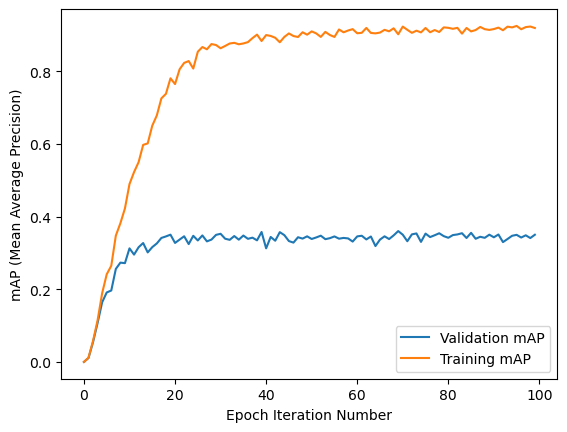

In [10]:
plt.plot(range(len(mAP_valid_list)), [x.item() for x in mAP_valid_list], label='Validation mAP')
plt.plot(range(len(mAP_train_list)), [x.item() for x in mAP_train_list], label='Training mAP')
plt.legend()
plt.xlabel("Epoch Iteration Number")
plt.ylabel("mAP (Mean Average Precision)")

In [40]:
import importlib
import sys
importlib.reload(sys.modules['utils'])
from utils import plot_bbox_and_label

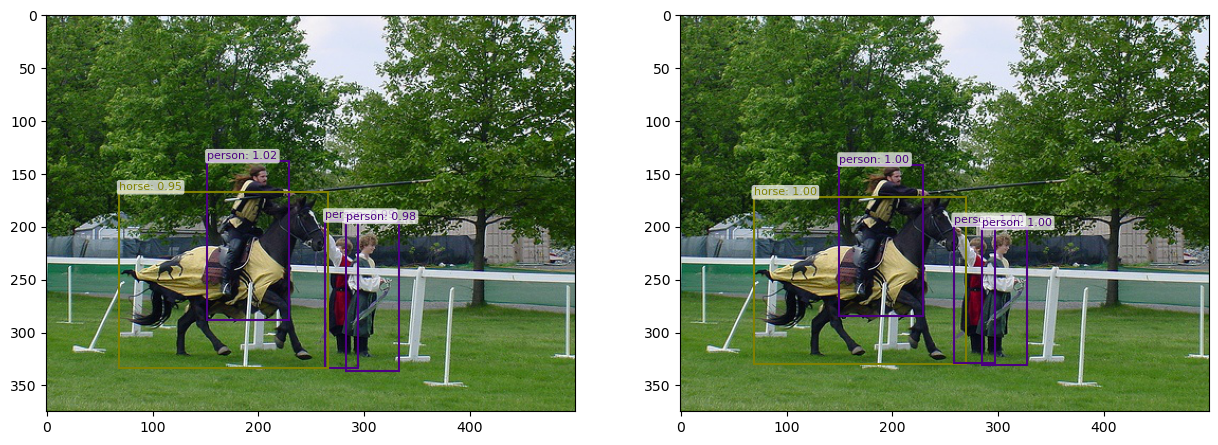

In [41]:
plot_bbox_and_label("train_trimmed.csv", 1, pred_boxes_train, target_boxes_train)

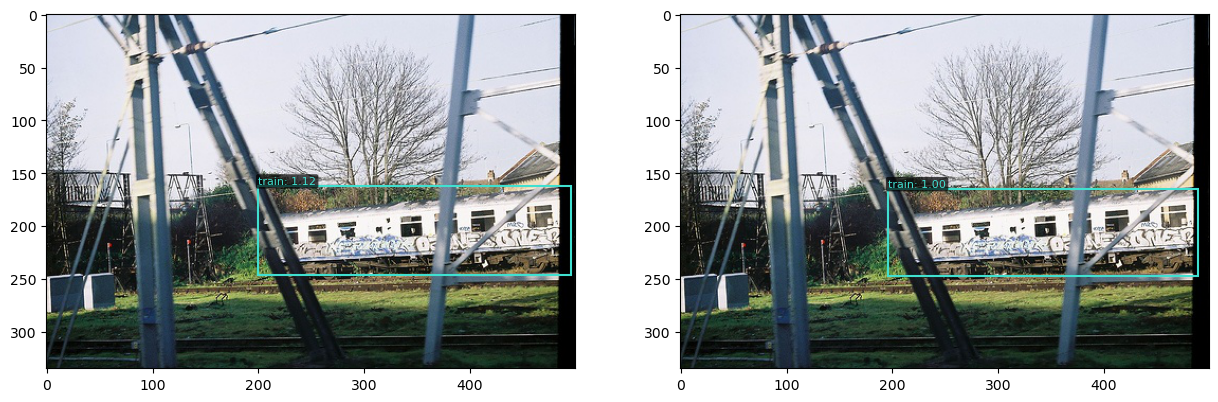

In [42]:
plot_bbox_and_label("train_trimmed.csv", 5, pred_boxes_train, target_boxes_train)

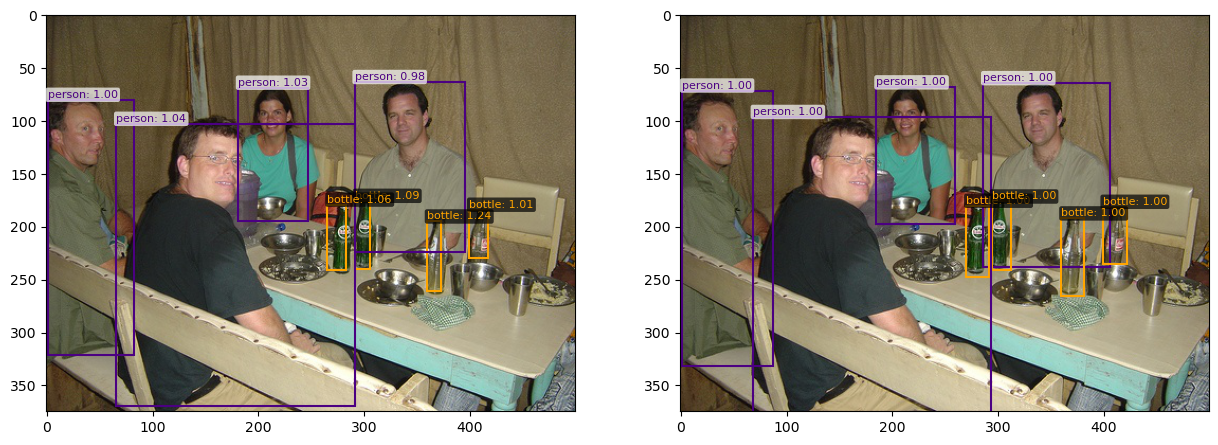

In [43]:
plot_bbox_and_label("train_trimmed.csv", 10, pred_boxes_train, target_boxes_train)

### Testing Results! 
Left is the predictions by our model, the right is the labeled test datapoint

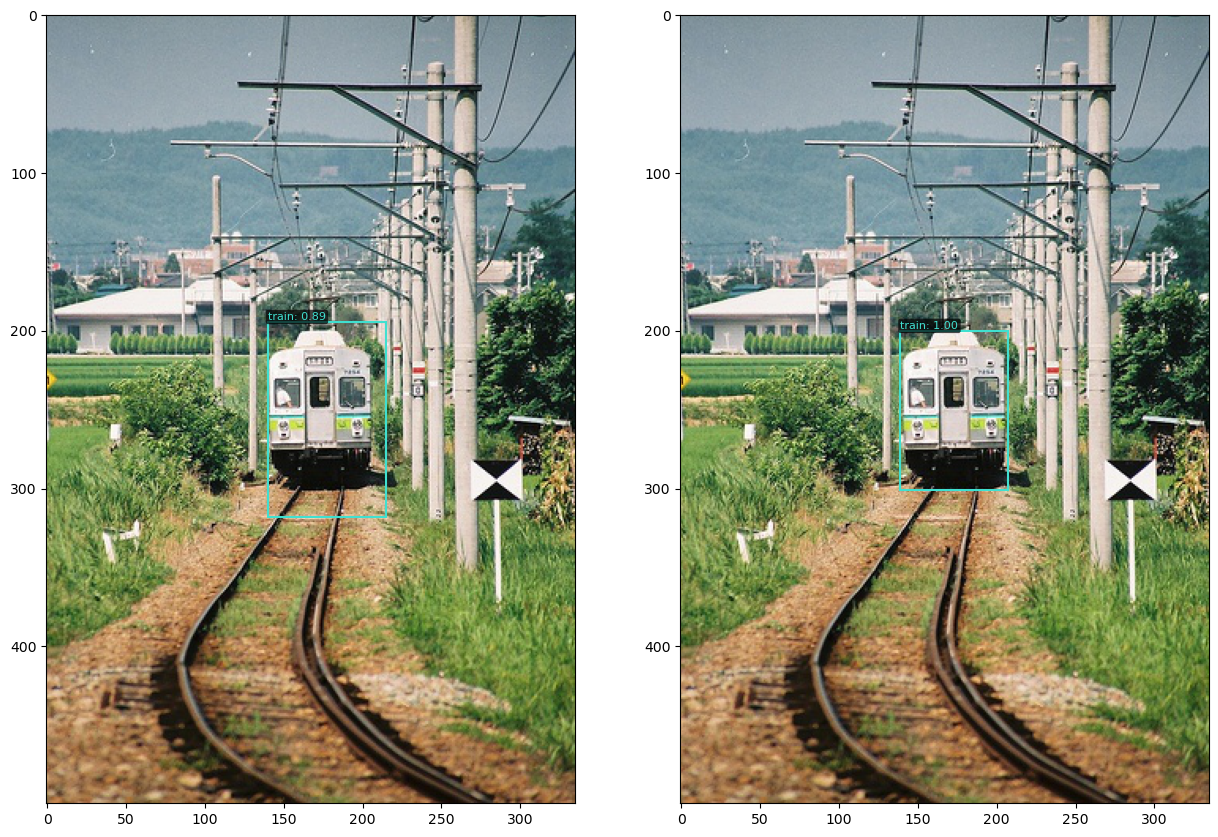

In [45]:
plot_bbox_and_label("test.csv", 0, pred_boxes_test, target_boxes_test)

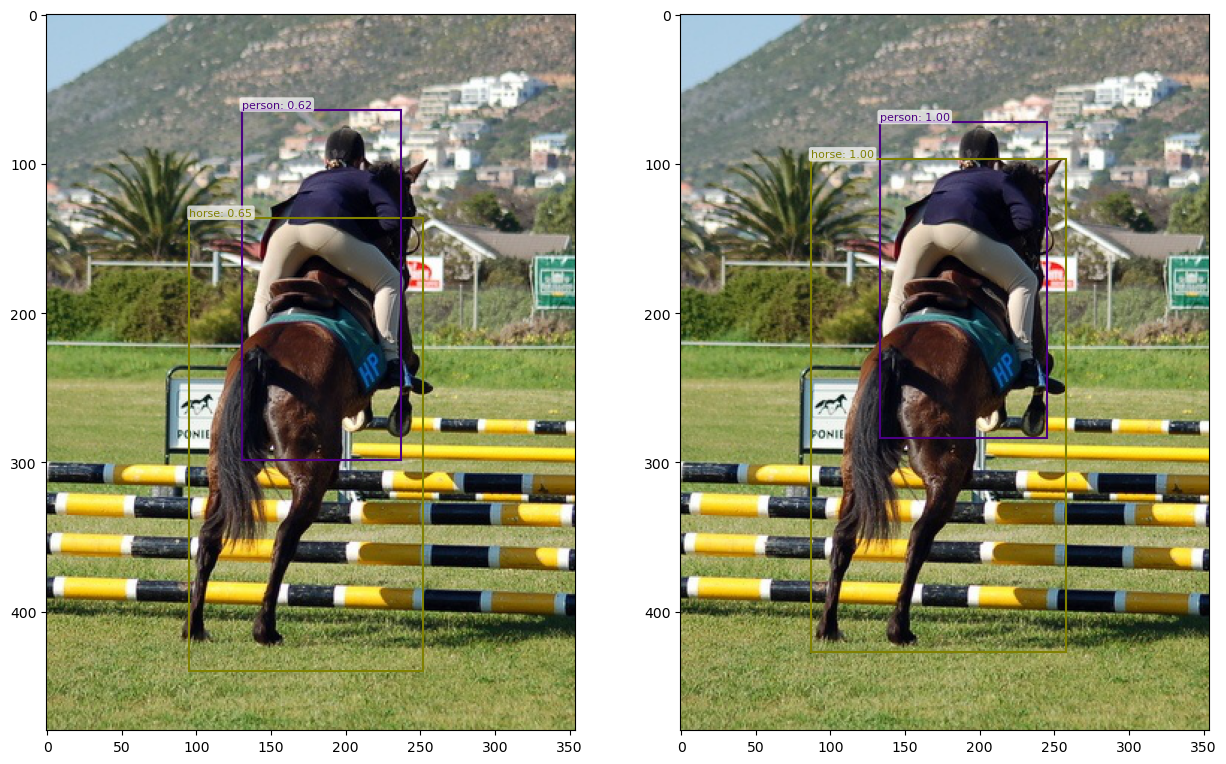

In [46]:
plot_bbox_and_label("test.csv", 5, pred_boxes_test, target_boxes_test)

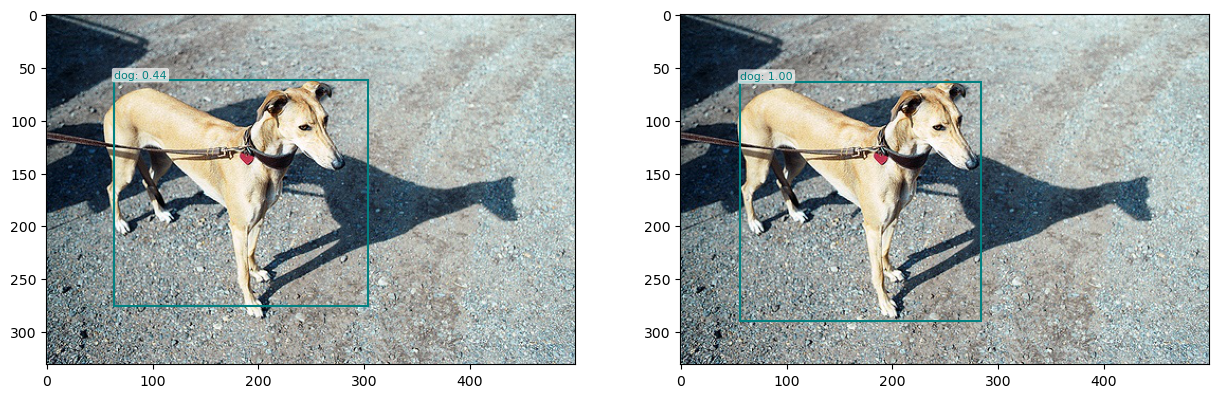

In [47]:
plot_bbox_and_label("test.csv", 15, pred_boxes_test, target_boxes_test)

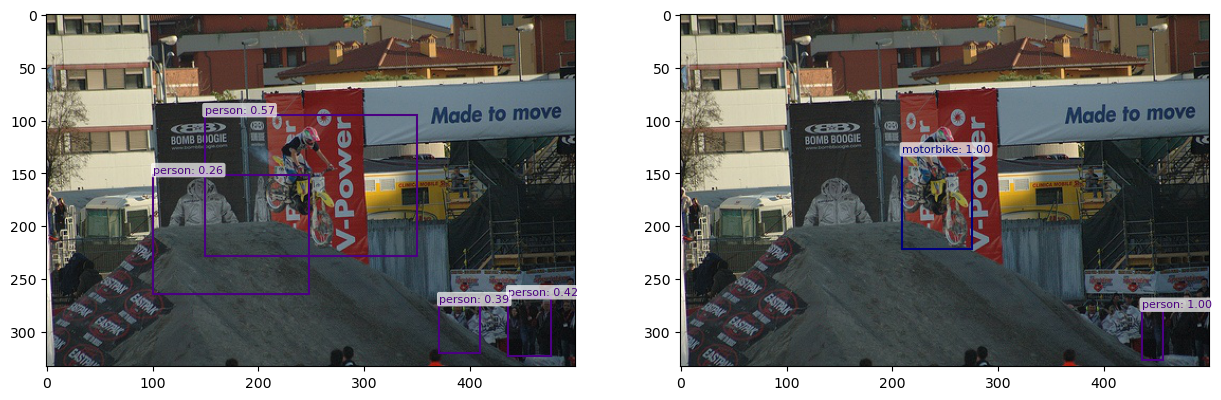

In [48]:
plot_bbox_and_label("test.csv", 25, pred_boxes_test, target_boxes_test)